In [273]:
import pickle
import os,sys,inspect
currentdir = os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe()))
        )
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/solve"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/visualization"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/data"))
import lloovia
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [275]:
import matplotlib
# Parámetros de las gráficas para publicación en artículo
sb_white=dict(matplotlib.style.library["seaborn-whitegrid"])
sb_paper=dict(matplotlib.style.library["seaborn-paper"])
my_settings = {
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.figsize": (3.5, 2.5),
    'grid.linestyle': '-',
    "grid.linewidth": 0.5,
    "grid.alpha": 0.5,
    "lines.markersize": 3,
    "lines.linewidth": 0.8,
    "text.usetex": False,   
    "font.family": "serif",
    "pgf.rcfonts": False,
    "font.serif": [],   
    "font.sans-serif": [],
    "font.monospace": [],
}
paper_style = {}
for x in [sb_white, sb_paper, my_settings]:
    paper_style.update(x)
    
# Parámetros para verlas en el notebook
notebook_style = {}
my_settings = {
   "figure.figsize": (7, 5)
}
for x in [dict(matplotlib.style.library["seaborn-darkgrid"]),
          dict(matplotlib.style.library["seaborn-notebook"])]:
    notebook_style.update(x)

# Synthetic experiments

## Cloud infrastructure parameters

The set of instace classes used in the synthetic experiments can be read from a pickle, and processed using Pandas to provide a summary table similar to Table 5 in the paper.

In [428]:
# Show the characteristics of the instances used in the experiments
instances = pd.read_pickle("/tmp/interim/instances_for_synthetic_experiments.pickle")
(pd.DataFrame([i.__dict__ for i in instances])
 [["name", "cloud", "performance", "price", "reserved"]]
 .assign(region=lambda x: x.cloud.astype(str).str.replace(" .*", ""))
 .drop("cloud", axis=1)
# .reset_index()
 .pivot_table(index=["name", "region"], columns="reserved", values=["price", "performance"])
 .sort_index()
 )

performance           price          
reserved                False    True   False     True 
name       region                                      
c3.2xlarge EU         46000.0  46000.0  0.478  0.307534
           US         46000.0  46000.0  0.420  0.247717
c3.large   EU         18000.0  18000.0  0.120  0.076598
           US         18000.0  18000.0  0.105  0.061872
c3.xlarge  EU         27000.0  27000.0  0.239  0.154224
           US         27000.0  27000.0  0.210  0.124772
m3.large   EU         11000.0  11000.0  0.146  0.100114
           US         11000.0  11000.0  0.133  0.081393
m3.medium  EU          9000.0   9000.0  0.073  0.049543
           US          9000.0   9000.0  0.067  0.040297
m3.xlarge  EU         39000.0  39000.0  0.293  0.199315
           US         39000.0  39000.0  0.266  0.163014

## Workload parameters

Several workload shapes were used in each experiment. They are stored in `.csv` files, each one containing several columns for different base-level. There are two files for each workload shape, one is used as LTWP for Phase I and the other as STWP for Phase II in the "realization" experiment. All were synthetically generated and they can be regenerated to perform a new set of experiments if desired. Refer to README.

This is the complete set of `.csv` files


In [429]:
!ls ../data/paper/traces_synthetic_*

../data/paper/traces_synthetic_decreasing_LTWP.csv
../data/paper/traces_synthetic_decreasing_STWP.csv
../data/paper/traces_synthetic_everything_LTWP.csv
../data/paper/traces_synthetic_everything_STWP.csv
../data/paper/traces_synthetic_increasing_LTWP.csv
../data/paper/traces_synthetic_increasing_STWP.csv
../data/paper/traces_synthetic_once_LTWP.csv
../data/paper/traces_synthetic_once_STWP.csv
../data/paper/traces_synthetic_periodic_LTWP.csv
../data/paper/traces_synthetic_periodic_STWP.csv
../data/paper/traces_synthetic_static_LTWP.csv
../data/paper/traces_synthetic_static_STWP.csv
../data/paper/traces_synthetic_unpredictable_LTWP.csv
../data/paper/traces_synthetic_unpredictable_STWP.csv


This is a plot which shows each workload shape, all for the LTWP version and base-level = 3000000. This is Fig. 8 in the paper

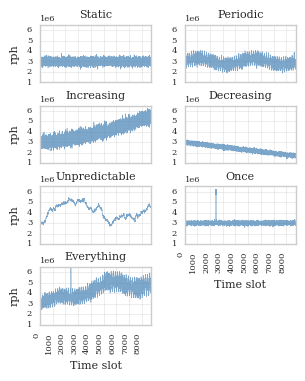

In [431]:
# Load all workloads from CSVs
cases = df.index.levels[0]            # Names of each case
dfw = pd.DataFrame()
for case in cases:
    data = pd.read_csv("../data/processed/traces_synthetic_{}_LTWP.csv".format(case.lower()),
                       index_col=0).T
    data["Case"] = case
    data["Level"] = data.index
    data.set_index(["Case", "Level"])
    dfw = dfw.append(data)
dfw = dfw.set_index(["Case", "Level"]).reindex().sort_index().T

# Plot them all in a single graph (only for base_level=3000000)

# Workloads
k = dfw.loc[:, pd.IndexSlice[:, "3000000"]].astype(float)
k.index.name = "Time slot"
# Nombres de los casos
k.columns = k.columns.get_level_values(0)

# Force this given order in the subplots
selection = ["Static", "Periodic", "Increasing", 
             "Decreasing", "Unpredictable", "Once", "Everything"]

with matplotlib.style.context(paper_style):
    axarr = k[selection].plot(subplots=True, sharex=True, layout=(4,2),
                              lw=0.4, color="steelblue", alpha=0.7, legend=False, 
                              rot=90,
                              figsize=(3.3,5))#, fontsize=7)
    plt.subplots_adjust(left=None, bottom=0.3, right=None, top=None,
                        wspace=0.3,  hspace=0.4)
    for ax, title in zip(axarr.flat, selection):
        ax.set_title(title)#, fontsize=11)
        # Lo siguiente fuerza a usar notación científica
        ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
        ax.set_ylim(1e6,6.5e6)
for ax in axarr[:,0]:
    ax.set_ylabel("rph", rotation=90)
plt.gcf().savefig("../reports/figures/synthetic-workloads.pgf", bbox_inches="tight")

## Solutions

There are 7 workload shapes, and each one in 4 different "base level", which makes a total of 28 scenarios. Each of these scenarios is solved several times: 

* Phase I is run 11 times over each scenario, for different value of `max_bins`, plus another one without binning (the "optimal"). This makes 28*12=336 experiments. We call this phase "I"
* Phase II is run 11 times, using the same prediction than phase I (perfect prediction) and using the number of reserved instances given by Phase I for each of the 11 cases of binning. This makes 28*11=308 additional experiments. We call this phase "II".
* Phase II is run again 11 times, for each solution with bins in phase "I", but using this time different workloads as STWP, to evaluate the sensibilty of the solution to the accuracy of the prediction. This makes 28*11=308 additional experiments. We call this phase "R" (Realization).
* An "Oracle" solution is found for each of the 28 scenarios. This oracle knows the future STWP and is able to obtain an optimal solution for the STWP. It is implemented by running phase I of lloovia without binning, but passing the STWP instead of the LTWP as input. This makes additional 28 experiments. We call this phase "O" (Oracle).

In total there are 980 experiments. In order to bound the total time required for running them all, we set timeouts to find the solution in each experiment. Phase "I" experiments are limited to 15 minutes for the cases with binning, and 1 hour for the cases without binning. Phase "II" and "R" do not use binning and they have a time limit per timeslot which is never reached (because a single timeslot solves usually very fast), so in practice they do not require any timeout. Phase "O" is run without binning and with a timeout of 1h.

Given the large number of experiments, the time to complete all of them is large (around 32h in a Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz). You can replicate the experiment using the Snakefiles provided, which automate all the workflow. Alternatively you can use the provided pickle which summarizes the results of all these experiments in a single dataframe, useful to explore and plot the data. All intermediate pickles produced during the analysis are not provided in this repository, because they take a large space in disk (~1.5Gb). Those pickles contain the individual allocation found by Lllovia for each timeslot of each of the 980 experiments.



### Read the final solution from file

In [463]:
df = pd.read_pickle("../data/processed/all_experiments_result.pickle")

The resulting dataframe is multi-indexed by the name of each case, the base-level, the phase and the number of `max_bins` used. There is one row per experiment. Fore example, here is the first one:

In [446]:
df.head(1)

,,,,cost,seconds_to_solve,seconds_to_create,frac_gap,max_seconds,status
Case,Base level,Phase,max_bins,,,,,,
Decreasing,50000,I,5,1677.188,0.048798,0.014099,0.01,900.0,optimal


It shows data about the case "Decreasing" with base level 50000, phase "I" with 5 bins. The only data stored per experiment is the final cost of the solution, the time required to create and solve the problem, some parameters passed to cbc (frac_gap and the timeout max_seconds), and the status of the solution. This status can be one of:

* `optimal` The solver ran until the end and found the optimal solution (for that number of bins)
* `aborted` The time limit given in `max_seconds` was reached, and no solution was found. In this case, the value of column `cost` is the best lower bound known by the solver at that point. 
* `overfull` This can only happen in phase "R", when the actual workload (STWP) is creater than predicted in LTWP. In this csae, is it possible that at some timeslots the workload cannot be fulfilled with the available ondemand instances. In this case Lloovia tries to maximize the performance during those timeslots, no matter the cost.

**Note about the timeout:** The value of `max_seconds` passed to the cbc solver is not "wall time". Cbc divides that time between the number of execution threads. In our case, we used a machine with two cores and ran cbc in two threads. This means that, when `max_seconds=900`, the solver will abort the execution if it runs for more than 450 seconds.

In [454]:
for phase in ["I", "II", "R", "O"]:
    print("Number of experiment results in phase %-2s = %d" % 
          (phase, len(df.query("Phase=='%s'" % phase ))))

Number of experiment results in phase I  = 336
Number of experiment results in phase II = 308
Number of experiment results in phase R  = 28
Number of experiment results in phase O  = 28


Some general statistics about the number of solved/aborted experiments, per phase. 

In [455]:
df.reset_index().groupby("Phase").status.value_counts()

Phase  status  
I      optimal     294
       aborted      42
II     optimal     281
O      aborted      14
       optimal      14
R      optimal      27
       overfull      1
Name: status, dtype: int64

## Phase I

### Graphics of solving time

In [492]:
def time_plot(all_data, case, level, 
              ax=None, legend=True, title=True, plot_phase_II=True):
    # Get the data for the given case and level
    data = all_data.loc[(case, level, "I"), 
                        ["seconds_to_create", "seconds_to_solve", "status"]
                       ].reset_index()   
    if title:
        title="{} {}".format(case, level)
    else:
        title=""
    labels = ["sec to create", "sec to solve"]
    ax = data.plot(x="max_bins", y="seconds_to_create",
                   title=title, marker="o", #ls="--", dashes=(1,1),
                   ax=ax, legend=legend)
    ax = data.plot(x="max_bins", y="seconds_to_solve",
                  marker="s", ls="solid",
                  ax=ax, legend=legend)
    
    if plot_phase_II:
        data2 = all_data.loc[(case, level, "II"), 
                ["seconds_to_create", "seconds_to_solve"]].reset_index()
        data2.plot(x="max_bins", y=["seconds_to_create", "seconds_to_solve"], 
                         marker="s", markersize=3, ax=ax, legend=legend)
        labels = [x + " I" for x in labels]
        labels+= ["sec to create II", "sec to solve II"]

    aborted = data[data.status.str.contains("aborted") |
                   data.status.str.contains("error")]
    if len(aborted):
        aborted.plot(ax=ax, x="max_bins", y=["seconds_to_solve"], 
                     linestyle="", color="y", 
                     marker = "D", markerfacecolor="white",
                     markeredgecolor="k", 
                     markeredgewidth=0.5,
                     legend=legend)
        labels+=["aborted"]
        
    ax.set_yscale("log")
    ax.set_xscale("log")
    requested_bins = [int(x) for x in data.max_bins.tolist()]
    requested_bins = [5, 20, 80, 400, 1600, 8760]
    ax.set_xticks(requested_bins)
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    ax.set_xlabel("Bins")
    ax.set_yticks([0.1, 1, 10, 60, 60*10, 60*60])
    ax.set_yticklabels(["0.1s", "1s", "10s", "1min", "10min", "1h"])
    ax.set_ylim(0,60*80)
    ax.set_xlim(0,10000)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if legend:
        L=ax.legend(labels=labels, loc="best")
    return ax

This function allows us to plot the relationship between the value of `max_bins` and the time required to create and solve each problem, for any of the cases and load-levels. For exmple:

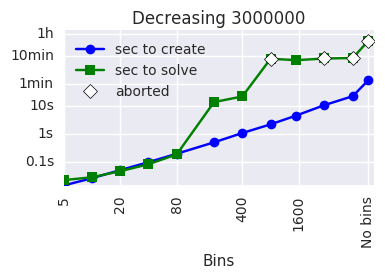

In [457]:
with matplotlib.style.context(notebook_style):
    time_plot(df, "Decreasing", 3000000, plot_phase_II=False)
    plt.gcf().set_size_inches((4,2))

The following code plots a grid with all cases and levels. It is Fig. 9 in the paper

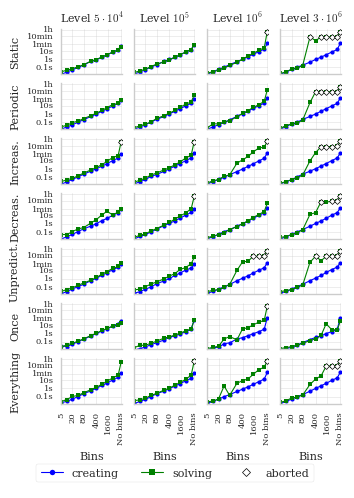

In [458]:
# Set the order of the rows in the grid of plots
casetitles = ["Static", "Periodic", "Increasing", "Decreasing",
              "Unpredictable", "Once", "Everything"]

# Select the order of the columns in the grid of plots
levels = [50000,100000,1000000,3000000]

with matplotlib.style.context(paper_style):
    # Create the subplots array
    f, axarr = plt.subplots (len(casetitles), len(levels), sharex=True, 
                             sharey=True, figsize=(15,30))

    # Plot each subplot
    for i,case in enumerate(casetitles):
        for j,level in enumerate(levels):
            a = time_plot(df, case, level, 
                          ax=axarr[i,j], legend=False, title=False, 
                          plot_phase_II=False)
            
    # Set the size of the figure for the paper
    f.set_size_inches(3.5,5)

    # Create titles for rows and columns. Some case names are abridged
    # to fit in the small space
    for ax, casetitle in zip(axarr[:,0], 
            ["Static", "Periodic", "Increas.", "Decreas.", 
             "Unpredict.", "Once", "Everything"]):
        ax.set_ylabel(casetitle, rotation=90)
        
    # For the column titles we use scientific notation to save space
    for ax, level in zip(axarr[0,:], ["5\cdot10^4", 
                                      "10^5", 
                                      "10^6", 
                                      "3\cdot10^6" ]):
        ax.set_title("Level ${}$".format(level))

    # Create a custom legend
    patches, labels = axarr[-1,-1].get_legend_handles_labels()
    f.legend(patches, labels=["creating", "solving", "aborted"], 
             bbox_to_anchor=(0.5, 0.05), loc="center",
             markerscale=1.3,
             ncol=3, shadow=False, fancybox=True, framealpha=0.8, 
             frameon=True)
    f.subplots_adjust(bottom=0.2, left=0.15,right=0.95, top=0.95)

## Phase II (Perfect Prediction)

### Overcost

In the dataframe we have the total cost (in dollars) of each solution. In order to compare each solution which used binning with the optimal solution which used no binning, it is more relevant to compute the percentage of overcost. It is defined as:

```
overcost = 100*(cost_of_solution_with_binning - cost_of_solution_without_binning)/cost_of_solution_without_binning
```

However in some cases the solution without binning is not available because the solver was aborted due to the timeout. In those cases, instead of the optimal cost we use the lower bound of the optimal cost. This comparison is conservative, in the sense that the actual overcost would be smaller.

In [476]:
import itertools
for case, level in itertools.product(df.index.levels[0], df.index.levels[1]):
    # We get the optimal solution from phase I, for each case/level
    optimal = df.loc[(case, level, "I"), "cost"].loc[8760]
    # Compute the overcost, and add it as a new column in the dataframe
    df.loc[pd.IndexSlice[case, level, "I":"II", :], "% overcost"] = (df.loc[
                           pd.IndexSlice[case, level, "I":"II", :],"cost"]
                                            -optimal)*100/optimal
    # For the realization phase we compare against the oracle
    oracle = df.loc[(case, level, "O"), "cost"].loc[8760]
    df.loc[pd.IndexSlice[case, level, "R", :], "% overcost"] = (df.loc[
                           pd.IndexSlice[case, level, "R", :],"cost"]
                                            -oracle)*100/oracle

The overcost is computed for both phases I, II and R, but in phase I it does not have much sense. Using binning, the solution in phase I is not optimal, and thus the overcost can be large. However, phase II will refine the result by recomputing the optimal number of ondemand instances with the actual workload, without binning, and this will reduce the overcost. So we will study only the overcost for phase II (both in "II" and "R" cases)

In [485]:
df.query("Phase=='II'").head()

cost  seconds_to_solve  \
Case       Base level Phase max_bins                               
Decreasing 50000      II    5         1626.268          0.151164   
                            10        1535.590        151.136600   
                            20        1535.590        168.320099   
                            40        1535.590        170.825480   
                            80        1535.590        162.678686   

                                      seconds_to_create frac_gap  max_seconds  \
Case       Base level Phase max_bins                                            
Decreasing 50000      II    5                  0.007354     None        600.0   
                            10                11.808506     None        600.0   
                            20                12.977067     None        600.0   
                            40                12.589924     None        600.0   
                            80                12.354026     None        600.0   

                                       status    % overcost  
Case       Base level Phase max_bins                         
Decreasing 50000      II    5         optimal  5.905092e+00  
                            10        optimal  3.287138e-12  
                            20        optimal  3.287138e-12  
                            40        optimal  3.287138e-12  
                            80        optimal  3.287138e-12

### Graphics of overcost

In [497]:
def plot_cost(all_data, case, level, ax = None,
              plot_phase_I = False, legend=True):  
    phase1 = all_data.loc[(case, level, "I"), :].reset_index()
    phase2 = all_data.loc[(case, level, "II"), :].reset_index()
    optimal_status = phase1.status.iloc[-1]
    if optimal_status=="aborted":
        label="% resp. best lower bound"
        style1 = dict(color="orange", ls="solid",
                     # dashes=(1,1),
                     marker="o", markerfacecolor="white",
                     markeredgecolor="k", 
                     markeredgewidth=0.5,
                     markersize=2.5,
                     label=label)
        style2 = style1.copy()
        style2.update(dict(color="red", marker="s"))
    elif optimal_status == "optimal":
        label = "% resp. optimal"
        style1 = dict(color="blue", ls="solid",
                     marker="o",
                     label=label)
        style2 = style1.copy()
        style2.update(dict(color="green", marker="o"))
    else:
        style1 = dict(color="orange", ls="solid",
                     marker="D",
                     label="% unknown")
        style2 = style1.copy().update(dict(color="red", marker="d"))
        
    labels = []
    if plot_phase_I:
        ax = phase1.plot(x="max_bins", y="% overcost", 
                         **style1, #marker=marker1,  label="% overcost I", color=color1, ls=ls, dashes=dashes,
                         ax=ax, legend=legend)
        labels.append("% overcost I")
        
    phase2.plot(x="max_bins", y="% overcost",
                **style2, # marker=marker2,  label=label, color=color2, ls=ls, dashes=dashes,
                ax=ax, legend=legend)
    labels.append(label)
    
    requested_bins = [int(x) for x in phase1.max_bins.tolist()]
    requested_bins = [5, 20, 80, 400, 1600, 8760]
    if ax==None:
        ax=plt.gca()

    ax.set_xscale("log")
    ax.set_xticks(requested_bins)
    ax.set_xlabel("Bins")
    if legend: 
        ax.legend(labels=labels, loc='upper right')
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    return ax

This function allows us to plot the relationship between the value of `max_bins` and the overcost of the solution with respect the optimal (or its lower bound), for any of the cases and load-levels. The graph is depicted in blue if the overcost is with respect the optimal, or in red if it is with respect to the best lower bound

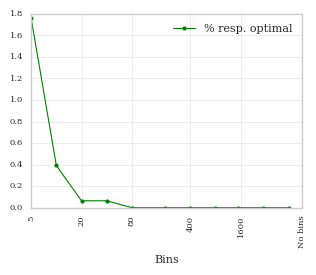

In [498]:
with matplotlib.style.context(paper_style):
    ax = plot_cost(df, "Periodic", 1000000, plot_phase_I=False)

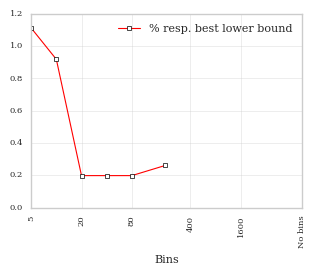

In [499]:
with matplotlib.style.context(paper_style):
    ax = plot_cost(df, "Periodic", 3000000, plot_phase_I=False)

As it can be seen in the above plot, the graph can be incomplete. In the example above there is no points for `max_bins` above 200. This happens when the solution of Phase I is not available for that number of bins, because of the timeout which aborted the solver. In such a case phase II cannot be performed (because Phase II needs as input the allocation found in phase I)

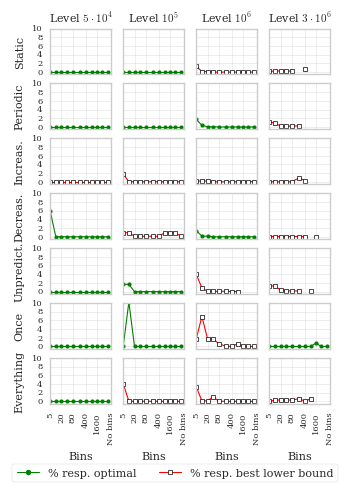

In [353]:
# Preparo qué casos quiero mostrar (y en qué orden)
casetitles = ["Static", "Periodic", "Increasing", "Decreasing",
              "Unpredictable", "Once", "Everything"]
levels = [5,10,100,300]

with matplotlib.style.context(paper_style):
    # Preparo un array de subplots
    f, axarr = plt.subplots (len(casetitles), len(levels), sharex=True, sharey=True, figsize=(15,30))

    # Hago el plot de cada caso, cada uno en su subplot correspondiente
    for i,case in enumerate(casetitles):
        for j,level in enumerate(levels):
            plot_cost(df, case, level*10000, ax=axarr[i,j],
                          plot_phase_I = False, legend=False)

    # Aumento el tamaño de la figura (por defecto muy pequeño)
    f.set_size_inches(3.5,5)
    #f.tight_layout()
    # f.suptitle("% Overcost resp. optimal or lower bound", y=1.03)

    # Pongo títulos a filas y columnas
    for ax, casetitle in zip(axarr[:,0], 
            ["Static", "Periodic", "Increas.", "Decreas.", "Unpredict.", "Once", "Everything"]
            ):
        ax.set_ylabel(casetitle, rotation=90)
        ax.set_ylim([-0.5,10])
    
    for ax, level in zip(axarr[0,:], ["5\cdot10^4", "10^5", "10^6", "3\cdot10^6" ]):
        ax.set_title("Level ${}$".format(level))
        ax.set_xlim(0,8760)
    patches0, labels = axarr[0,0].get_legend_handles_labels()
    patches1, labels = axarr[-1,-1].get_legend_handles_labels()
    patches = patches0 + patches1
    f.legend(patches, labels=["% resp. optimal", "% resp. best lower bound"], 
             bbox_to_anchor=(0.5, 0.05), loc="center",
             markerscale=1.3,
             ncol=2, shadow=False, fancybox=True, framealpha=1, 
             frameon=True)
    f.subplots_adjust(bottom=0.2, left=0.15,right=0.95, top=0.95)

# Real traces: Wikipedia

## Binning analysis

In [513]:
wikidata = pd.read_pickle("../data/processed/all_wikipedia_results.pickle")

In [515]:
wikidata.reset_index().groupby("Phase").status.value_counts()

Phase  status 
I      optimal    11
       aborted     1
II     optimal    11
O      aborted     2
R      optimal     2
Name: status, dtype: int64

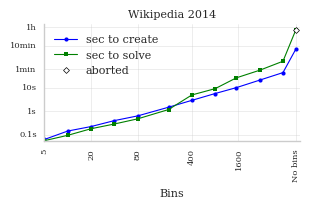

In [522]:
with matplotlib.style.context(paper_style):
    ax = time_plot(wikidata, "Wikipedia", 2014, plot_phase_II=False)
    plt.gcf().set_size_inches(3.3,1.5)
    plt.gcf().savefig("../reports/figures/fig-012-time-to-solve.pgf",
                     bbox_inches="tight")

In [517]:
s = wikidata.loc[("Wikipedia", 2014, "II")].copy()
best_bound = wikidata.loc[("Wikipedia", 2014, "I", 24*365)].cost

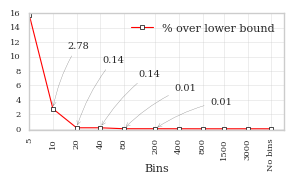

In [518]:
s["% over lower bound"] = np.round((s.cost - best_bound)/best_bound * 100, 5)

with matplotlib.style.context(paper_style):
    ax = s.plot(y="% over lower bound", color="red",
               figsize=(3.3,1.5), marker="s",
               markerfacecolor="white",
               markeredgecolor="k", 
               markeredgewidth=0.5
               )

    ax.set_xscale("log")
    requested_bins = [int(x) for x in s.index]
                    # [5, 10, 20, 40, 80, 200, 400, 800, 1600, 3000, 6000, 8760]
    ax.set_xticks(requested_bins)
    ax.set_xticklabels(requested_bins[:-1] + ["No bins"], rotation='vertical')
    ax.set_xlabel("Bins", labelpad=-5)
    ax.set_ylim(-0.1, 16)
    ax.set_xlim(4.9, 8760)
    annotate_subset = s.loc[10:200,["% over lower bound"]].to_records()
    for n,(i,j) in enumerate(annotate_subset):
        ax.annotate("{:1.2f}".format(j),
                    xy=(i,j), 
                    textcoords="axes fraction",  fontsize=7,
                    xytext=(0.15+0.7/len(annotate_subset)*n, 0.7-0.6/len(annotate_subset)*n),
                    arrowprops=dict(arrowstyle="->",  alpha=0.5, color="k", connectionstyle="arc3,rad=0.1")
                    )
    plt.gcf().savefig("../reports/figures/fig-013-cost-vs-bins-labelled.pgf",
                    bbox_inches="tight")

## Influence of the prediction

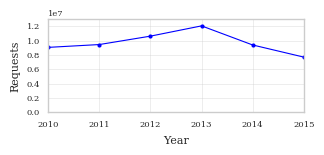

In [527]:
workload = pd.read_csv("../data/processed/traces_en_wikipedia.csv", 
                   sep=";", names=["time", "requests"], header=None)
workload.time = pd.to_datetime(workload.time)
workload = workload.set_index(workload.time)
with matplotlib.style.context(paper_style):
    workload.resample('A').mean().plot(marker="o", ylim=0, legend=None, 
                            figsize=(3.3, 1.2))
    plt.xlabel('Year')
    plt.ylabel('Requests')
    # plt.gcf().savefig("../public/latex/paper/fig-010-wikipedia-load-per-year.pgf",
    #                 bbox_inches = 'tight')

In [530]:
len(workload["2012"])

8784

In [591]:
_x = pickle.load(open("/tmp/interim/phaseI/case_wikipedia_2014_multi_Azure_bins_40.pickle", "rb"))

In [592]:
_x.solving_stats

SolvingStatsI(max_bins=40, workload=LlooviaHistogram(30 elements), frac_gap=None, max_seconds=3600, creation_time=0.04349871282465756, solving_time=0.12526315706782043, status='optimal', lower_bound=None, optimal_cost=3582.3019999999992)

In [593]:
_x.compute_reserved_performance()

612000.0

In [594]:
_kk = _x.get_allocation_with_data()

In [595]:
_kk

VM  506665.325  \
provider rsv   Name           LS                                                
azure    False Basic_A0       us-east-2        Basic_A0_us-east-2         3.0   
               Standard_D1_v2 us-east-2  Standard_D1_v2_us-east-2         0.0   
               Standard_D2_v2 us-east-2  Standard_D2_v2_us-east-2         0.0   

                                         2533326.625  4053322.6  5573318.575  \
provider rsv   Name           LS                                               
azure    False Basic_A0       us-east-2          0.0        1.0          0.0   
               Standard_D1_v2 us-east-2          2.0        1.0          2.0   
               Standard_D2_v2 us-east-2          0.0        1.0          1.0   

                                         6079983.9  6586649.225000001  \
provider rsv   Name           LS                                        
azure    False Basic_A0       us-east-2        0.0                2.0   
               Standard_D1_v2 us-east-2        4.0                4.0   
               Standard_D2_v2 us-east-2        0.0                0.0   

                                         7093314.55  7599979.875  8106645.2  \
provider rsv   Name           LS                                              
azure    False Basic_A0       us-east-2         0.0          0.0        1.0   
               Standard_D1_v2 us-east-2         3.0          5.0        5.0   
               Standard_D2_v2 us-east-2         1.0          0.0        0.0   

                                         ...    15199959.75  \
provider rsv   Name           LS         ...                  
azure    False Basic_A0       us-east-2  ...            0.0   
               Standard_D1_v2 us-east-2  ...           10.0   
               Standard_D2_v2 us-east-2  ...            0.0   

                                         15706625.075000001  16213290.4  \
provider rsv   Name           LS                                          
azure    False Basic_A0       us-east-2                 0.0         2.0   
               Standard_D1_v2 us-east-2                10.0        10.0   
               Standard_D2_v2 us-east-2                 0.0         0.0   

                                         16719955.725  17226621.05  \
provider rsv   Name           LS                                     
azure    False Basic_A0       us-east-2           0.0          0.0   
               Standard_D1_v2 us-east-2           9.0         11.0   
               Standard_D2_v2 us-east-2           1.0          0.0   

                                         17733286.375  19253282.35  \
provider rsv   Name           LS                                     
azure    False Basic_A0       us-east-2           2.0          2.0   
               Standard_D1_v2 us-east-2          11.0         12.0   
               Standard_D2_v2 us-east-2           0.0          0.0   

                                         20266613.0       perf  price  
provider rsv   Name           LS                                       
azure    False Basic_A0       us-east-2         0.0   204000.0  0.018  
               Standard_D1_v2 us-east-2        13.0  1586400.0  0.064  
               Standard_D2_v2 us-east-2         0.0  2456400.0  0.127  

[3 rows x 33 columns]

In [596]:
_x.compute_reserved_performance()

612000.0

In [597]:
_kk.loc[pd.IndexSlice[:,True],]

KeyError: True

In [598]:
_kk.query("rsv==True")

,,,,VM,506665.325,2533326.625,4053322.6,5573318.575,6079983.9,6586649.225000001,7093314.55,7599979.875,8106645.2,...,15199959.75,15706625.075000001,16213290.4,16719955.725,17226621.05,17733286.375,19253282.35,20266613.0,perf,price
provider,rsv,Name,LS,,,,,,,,,,,,,,,,,,,,,
